# MovieLens recommendations in Keras and TensorFlow

This notebook demonstrates a Keras model for recommending movies. It's an example of one of the things I like about deep learning -- you can use the same model, trained on the same data, for multiple different tasks. In this case, those tasks are personalized and non-personalized recommendations.

It's derived originally from [an example by Maciej Kula](https://github.com/maciejkula/triplet_recommendations_keras). In this fork I did quite a few additional things that aren't in the original:

* Incorporated genre metadata into the model
* Modified the loss function to match the [BPR paper](https://arxiv.org/abs/1205.2618)
* Added a non-linear transformation into the model
* Wrote log data and metadata out in TensorBoard format to enable visualization of embeddings
* Provided a function to actually query the recommendations for a given user
* Provided a function to query the model by movie, and return similar movies

It's also had a few tweaks to let it run without warnings in Keras 2.

In [2]:
from __future__ import print_function

import heapq

import numpy as np

from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Lambda
from keras.layers.merge import concatenate, dot
from keras.layers.advanced_activations import ELU
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

import data
import metrics
from net_helpers import *

import graphviz
import pydot_ng as pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

## Network architecture

From a high-level perspective, this network is a **pairwise personalized ranking model**. Given a user and two movies from the training data, it learns to give a higher score to the one which the user preferred. (However, as we'll see below, you can also use it for non-personalized, similarity-based ranking.)

This architecture is sometimes called a **triplet network**, although that terminology [originally meant](https://arxiv.org/abs/1412.6622) a model that takes three inputs of the _same_ type (e.g. three movies).

Each user, movie, and genre tag is represented by an embedding -- a vector of floats, i.e. some coordinates in a high dimensional space -- which is initialized randomly and updated as the model trains. So, over time:

* Users with similar tastes will be pushed closer to each other in user embedding space
* Movies which appeal to similar people will be pushed closer to each other in movie embedding space
* Tags which appear in similar contexts will be pushed closer together in tag embedding space

Some movies have multiple genres, e.g. _Alien_ is tagged 'Action', 'Horror', 'Sci-Fi', 'Thriller'. In these cases, the tag embeddings are simply averaged together. The final representation for a movie is its own embedding concatenated with the average of its tag embeddings.

The network's weights are shared between the positive and negative examples -- i.e. the movie and tag embedding tables. This means we learn a single embedding for each movie and each tag, not different embeddings for positive and negative context. This architecture is sometimes called a [Siamese network](https://www.quora.com/What-are-Siamese-neural-networks-what-applications-are-they-good-for-and-why).

To make predictions, we use a slightly modified version of the network, with _just one_ movie input (and a user input). This outputs a personalized ranking score for that movie, that can be used to sort that user's recommendations.

We also return a version of the network with _two_ movie inputs and _no_ user input, for ranking movies by similarity.

In [3]:
def build_model(num_users, num_items, num_tags, max_tags,
                item_latent_dim, tag_latent_dim):
    
    """
    Build a model for training, plus submodels for personal ranking
    and movie-movie similarity.
    
    You need to supply the dimensionality of the movie and genre tag
    embedding spaces; the user embedding is sized automatically to be
    equal to the sum of these, e.g. 75d movies and 25d tags will give
    you a 100d user embedding.
    
    Args:
        num_users (int): the number of users in the dataset
        num_items (int): the number of movies in the dataset
        num_tags (int): the number of distinct genre tags in the dataset
        max_tags (int): the maximum number of tags associated with a single movie
        item_latent_dim (int): the size of the movie embedding to learn
        tag_latent_dim (int): the size of the tag embedding to learn
        
    Returns:
        The training model, the prediction model, the similarity model
    """

    # These inputs take movie IDs for the positive and negative items
    positive_item_input = Input((1, ), name='positive_item_input')
    negative_item_input = Input((1, ), name='negative_item_input')
    
    # These take zero-padded tag ID vectors, for the positive and negative items
    positive_tags = Input((max_tags, ), name='positive_tags')
    negative_tags = Input((max_tags, ), name='negative_tags')

    # Shared embedding layer for positive and negative items
    item_embedding_layer = Embedding(
        num_items, item_latent_dim, name='item_embedding', input_length=1)
    
    # Shared embedding layer for positive and negative items' tags
    tag_embedding_layer = Embedding(
        num_tags, tag_latent_dim, name='tag_embedding',
        input_length=max_tags, mask_zero=True)

    # Get the embeddings corresponding to the positive and negative movie IDs;
    # Flatten just turns a matrix with one row into a vector
    
    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))
    
    # Get the embeddings for the positive and negative tags, and average them
    # together via mask_aware_mean -- see comments in net_helpers.py
    
    positive_tags_embedding = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='pos_mean')(
        zero_mask(tag_embedding_layer(positive_tags)))
    
    negative_tags_embedding = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='neg_mean')(
        zero_mask(tag_embedding_layer(negative_tags)))
    
    # Concatenate the movie embeddings and mean tag embeddings for the two
    # inputs, then add an Exponential Linear Unit to give the network a
    # little more flexibility
    
    positive_vec = ELU()(concatenate([positive_item_embedding, positive_tags_embedding]))
    
    negative_vec = ELU()(concatenate([negative_item_embedding, negative_tags_embedding]))
    
    # Input for the user ID
    user_input = Input((1, ), name='user_input')

    # User embedding has to have dimensionality equal to item plus tag embeddings,
    # as they need to align element-wise when calculating the scores
    user_latent_dim = item_latent_dim + tag_latent_dim
    
    # Retrieve the user embedding and add an ELU as above
    user_embedding = ELU()(Flatten()(Embedding(
        num_users, user_latent_dim, name='user_embedding', input_length=1)(
            user_input)))
    
    # Now, the final representation for each movie (positive_vec/negative_vec)
    # is an ELU-transformed concatenation of the movie embedding and the mean
    # tag embedding
    
    # The final representation for the user is just her ELU-transformed embedding

    # Bayesian Personalized Ranking loss (see net_helpers.py)
    loss = BprLoss(name='bpr_loss')([positive_vec, negative_vec, user_embedding])

    # Construct and compile the main model for training, with positive and
    # negative movies plus user
    
    model = Model(
        inputs=[positive_item_input, positive_tags, negative_item_input, negative_tags, user_input],
        outputs=loss)
    
    model.compile(loss=identity_loss, optimizer=Adam())
    
    # Now define a separate model for prediction, with only one movie plus user,
    # which just calculates a score by taking the dot product of the user
    # representation and the movie representation
    
    # This doesn't have any additional weights of its own, it's just a subgraph
    # of the main model but with a different output layer
    
    user_dot_item = dot(
        [positive_vec, user_embedding], axes=-1, name='user_dot_item')
    
    pred_model = Model(
        inputs=[positive_item_input, positive_tags, user_input],
        outputs=user_dot_item)
    
    # Likewise, we can define a separate model for movie-movie similarity,
    # using both movie inputs and no user input
    
    # Note that they're still called 'positive' and 'negative' because we're
    # reusing previously-defined components, although when we use this model
    # for similarity, the input will just be two movies with no implied order
    
    item_item_cos_sim = dot(
        [positive_vec, negative_vec], axes=-1,
        normalize=True, # i.e. cosine similarity instead of inner product
        name='item_item_cos_sim')
    
    sim_model = Model(
        inputs=[positive_item_input, positive_tags, negative_item_input, negative_tags],
        outputs=item_item_cos_sim)

    return model, pred_model, sim_model

## Load and transform data
We're going to load the Movielens 100k dataset and create triplets of (user, known positive item, randomly sampled negative item).

The success metric is AUC: in this case, the probability that a randomly chosen known positive item from the test set is ranked higher for a given user than a randomly chosen negative item.

In [4]:
# Read data
train, test = data.get_movielens_data()
num_users, num_items = train.shape

item_features = data.get_movielens_item_metadata()

max_tags = item_features.shape[1]
num_tags = item_features.max() + 1

# Prepare the test triplets
test_uid, test_pid, test_nid = data.get_triplets(test)

# Generate the simplified metadata files for TensorBoard
log_dir = '/tmp/tfboard/triplet_keras/'
items_metadata, tags_metadata = data.init_tensorboard_metadata(log_dir)

## Build and inspect the models

Now we can build both the main training model, and the simpler prediction and similarity models, and verify their structure. If you want to display the input and output tensor shapes in the model diagrams, set `show_tensor_shapes=True` in the next cell.

In [18]:
item_latent_dim = 20
tag_latent_dim = 10

model, pred_model, sim_model = build_model(
    num_users, num_items, num_tags, max_tags,
    item_latent_dim, tag_latent_dim)

show_tensor_shapes=False

def render(network):
    figure = model_to_dot(network, show_shapes=show_tensor_shapes)
    return SVG(figure.create(prog='dot', format='svg'))

# Sanity check, should be around 0.5
print('AUC before training %s' % metrics.full_auc(pred_model, test, item_features))

AUC before training 0.498525458708


### Full model structure

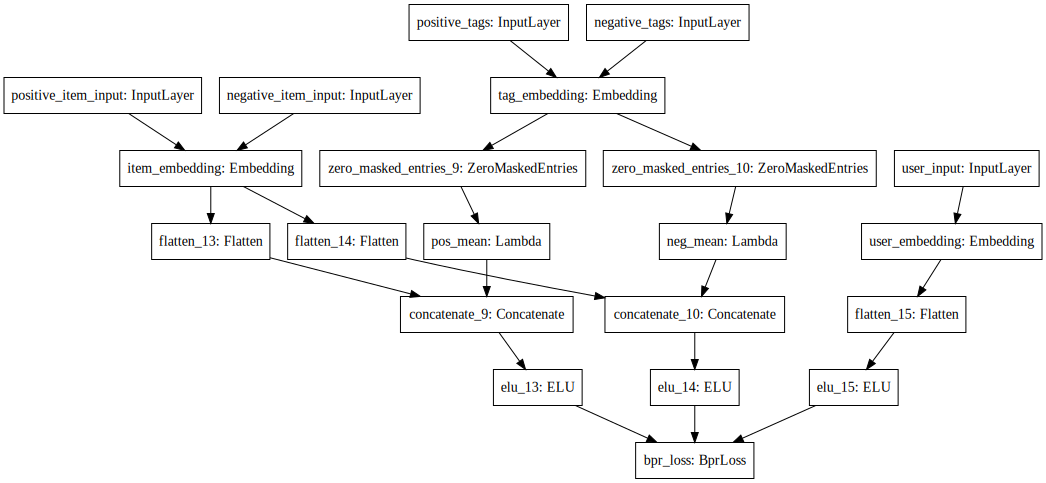

In [19]:
render(model)

### Prediction model structure

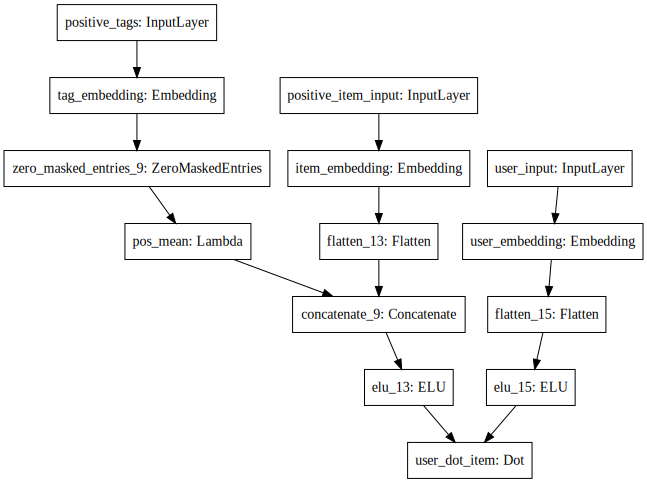

In [20]:
render(pred_model)

### Movie similarity model structure

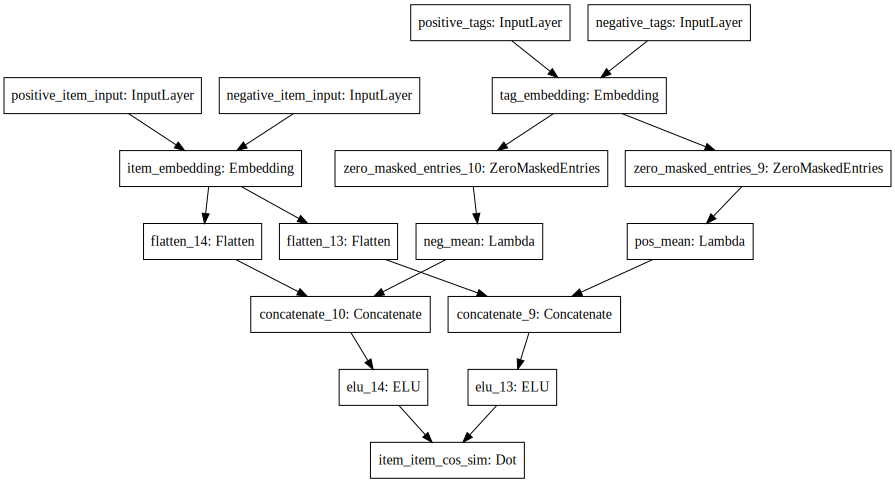

In [21]:
render(sim_model)

## Train the model

Run for a few epochs, checking the AUC after every epoch.

We'll get Keras to write out some training stats and the model weights to `log_dir` so we can explore them in [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) afterwards.

In [22]:
tensorboard = TensorBoard(
    log_dir=log_dir,
    embeddings_freq=1,
    embeddings_layer_names=['item_embedding', 'tag_embedding', 'user_embedding'],
    embeddings_metadata={'item_embedding': items_metadata, 'tag_embedding': tags_metadata})

num_epochs = 40
checkpoint_every = 10

for epoch in range(num_epochs):

    print('Epoch %s...' % epoch, end='')

    # Sample triplets from the training data
    uid, pid, nid = data.get_triplets(train)
    ptags = item_features[pid]
    ntags = item_features[nid]

    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid,
        'positive_tags': ptags,
        'negative_tags': ntags
    }
    
    checkpoint = ((epoch + 1) % checkpoint_every == 0)
    
    if checkpoint:
        callbacks=[tensorboard]
    else:
        callbacks=[]

    # We fit the model using dummy labels which are all one,
    # see net_helpers.py for why this is needed
    result = model.fit(X,
                       np.ones(len(uid)),
                       batch_size=64,
                       epochs=1,
                       verbose=0,
                       shuffle=True,
                       callbacks=callbacks)

    print('\tLoss = %0.4f' % result.history['loss'][0])
    
    if checkpoint:
        print('AUC %0.4f' % metrics.full_auc(pred_model, test, item_features))
        # TODO save model to disk

Epoch 0...	Loss = 1.6720
Epoch 1...	Loss = 1.4495
Epoch 2...	Loss = 1.3374
Epoch 3...	Loss = 1.3120
Epoch 4...	Loss = 1.2961
Epoch 5...	Loss = 1.2844
Epoch 6...	Loss = 1.2760
Epoch 7...	Loss = 1.2714
Epoch 8...	Loss = 1.2638
Epoch 9...	Loss = 1.2556
AUC 0.8912
Epoch 10...	Loss = 1.2466
Epoch 11...	Loss = 1.2424
Epoch 12...	Loss = 1.2375
Epoch 13...	Loss = 1.2289
Epoch 14...	Loss = 1.2254
Epoch 15...	Loss = 1.2196
Epoch 16...	Loss = 1.2164
Epoch 17...	Loss = 1.2153
Epoch 18...	Loss = 1.2083
Epoch 19...	Loss = 1.2044
AUC 0.9104
Epoch 20...	Loss = 1.2049
Epoch 21...	Loss = 1.2012
Epoch 22...	Loss = 1.1986
Epoch 23...	Loss = 1.1959
Epoch 24...	Loss = 1.1922
Epoch 25...	Loss = 1.1905
Epoch 26...	Loss = 1.1883
Epoch 27...	Loss = 1.1898
Epoch 28...	Loss = 1.1876
Epoch 29...	Loss = 1.1833
AUC 0.9164
Epoch 30...	Loss = 1.1839
Epoch 31...	Loss = 1.1792
Epoch 32...	Loss = 1.1794
Epoch 33...	Loss = 1.1736
Epoch 34...	Loss = 1.1732
Epoch 35...	Loss = 1.1747
Epoch 36...	Loss = 1.1717
Epoch 37...	Los

## Results

When this completes, you should see an AUC of at least 0.91 above. If you train for much longer, it'll start to overfit, since there's no regularization.

Now go to a terminal and run:

`tensorboard --logdir=/tmp/tfboard/triplet_keras/`

and then open this link:

http://localhost:6006/ (seems to work in Chrome only... thanks Google)

That'll let you visualize the learning curve during training, and explore the embeddings graphically.

Note that the movie embeddings in TensorBoard are somewhat misleading, as they _don't_ take into account the genre tags for each movie. We'll return to this shortly.

## Querying the model by user

For demo purposes, let's write a function that takes a user ID, and shows you what items they've liked already, and what the model's best-bet recommendations are.

We do this by preparing a batch of user/movie/genre inputs, one per each of the _n_ movies that the user hasn't seen -- really we're making _n_ separate predictions -- then we find the top-scoring ones and return these. We're just querying one user at a time, so the user ID is repeated _n_ times in the batch.

This uses the secondary model `pred_model` which only needs inputs for _one_ movie and a user.

In [23]:
all_item_ids = np.arange(num_items, dtype=np.uint16)
names = np.array(data.get_movie_names())

# NB in production, we might want to port this from numpy into tensorflow, for speed

def query_for_user(user_id, limit=5):
    
    # First, find out what they've already liked, so we can exclude these
    prev_liked = train.getrow(user_id).nonzero()[1]
    print('User %d has previously liked:\n' % user_id)
    print('\n'.join(np.sort(names[prev_liked])))
    
    # Build the query batch
    candidate_ids = np.setdiff1d(all_item_ids, prev_liked, assume_unique=True)
    candidate_tags = item_features[candidate_ids]
    num_candidates = len(candidate_ids)
    user_id_array = np.repeat(user_id, num_candidates)
    
    # Query the model
    predictions = pred_model.predict({
        'positive_item_input': candidate_ids,
        'positive_tags': candidate_tags,
        'user_input': user_id_array},
        batch_size=num_candidates)
    
    # Get the indices (in the candidates array) of the highest-valued outputs
    top_hits = heapq.nlargest(
        limit, xrange(num_candidates), predictions.take)
    
    # Now display them
    print('\nTop recommendations:\n')
    for hit_idx in top_hits:
        score = predictions[hit_idx]
        id = candidate_ids[hit_idx]
        print('%0.2f\t%s' % (score, names[id]))

In [24]:
query_for_user(600)

User 600 has previously liked:

Alien (1979)
Alien 3 (1992)
Aliens (1986)
Ben-Hur (1959)
Big Blue, The (Grand bleu, Le) (1988)
Blade Runner (1982)
Boot, Das (1981)
Braveheart (1995)
Butch Cassidy and the Sundance Kid (1969)
Die Hard 2 (1990)
Die Hard: With a Vengeance (1995)
Empire Strikes Back, The (1980)
Fugitive, The (1993)
Full Metal Jacket (1987)
Full Monty, The (1997)
Geronimo: An American Legend (1993)
Get Shorty (1995)
Glory (1989)
Godfather: Part II, The (1974)
Good, The Bad and The Ugly, The (1966)
GoodFellas (1990)
In the Line of Fire (1993)
Indiana Jones and the Last Crusade (1989)
Jurassic Park (1993)
Last of the Mohicans, The (1992)
Lawrence of Arabia (1962)
Magnificent Seven, The (1954)
Man Who Would Be King, The (1975)
Miller's Crossing (1990)
Natural Born Killers (1994)
Nick of Time (1995)
Pulp Fiction (1994)
Raiders of the Lost Ark (1981)
Return of the Jedi (1983)
Seven (Se7en) (1995)
Speed (1994)
Star Trek IV: The Voyage Home (1986)
Star Trek V: The Final Frontier (1

Notice that these scores are unbounded, because they're calculated from the [dot product](https://en.wikipedia.org/wiki/Dot_product) of the user and movie representations, which isn't a normalized quantity. This is useful as it can give us some comparative measure of quality between different result sets. If a user's top hits score very low compared to most other users' top hits, that can be a sign that we don't have enough data about that user or those movies to be confident about the recommendations.

## Querying the model by movie

We can also use the model to rank candidate movies by similarity to a query movie, using the other secondary model, `sim_model`. This requires _two_ movies -- fed into the model's 'positive' and 'negative' inputs, although this isn't actually important here -- and _no user_. As above, we just retrieve all the similarity scores for a query movie in a single batch, then find the top hits.

The results returned by this method will generally make more sense than the 'nearest points in [item] embedding space' that TensorBoard provides. This is because that TensorBoard view is based _purely_ on the similarities between the item embeddings themselves, but the model is actually trained on item representations that include mean tag embeddings too, and a non-linear activation function.

When we query `sim_model`, it constructs these higher-level item representations in exactly the same way, and _then_ calculates similarity scores.

In [25]:
# NB in production, we might want to port this from numpy into tensorflow, for speed

def query_for_item(item_id, limit=5):
    
    print('Showing similar items to %s:\n' % names[item_id])
    
    # Replicate the query ID and its tags across the whole batch
    query_ids = np.repeat(item_id, num_items)
    query_tags = np.tile(item_features[item_id], [num_items, 1])

    # 'positive' is the query item, this is arbitrary tho
    predictions = sim_model.predict({
        'positive_item_input': query_ids,
        'positive_tags': query_tags,
        'negative_item_input': all_item_ids,
        'negative_tags': item_features},
        batch_size=num_items)

    # Get the indices of the highest-valued outputs
    top_hit_ids = heapq.nlargest(
        limit, xrange(num_items), predictions.take)
    
    # Now display them
    for id in top_hit_ids:
        print('%0.2f\t%s' % (predictions[id], names[id]))

In [26]:
query_for_item(183)

Showing similar items to Alien (1979):

1.00	Alien (1979)
0.94	Jaws (1975)
0.89	Terminator, The (1984)
0.88	Terminator 2: Judgment Day (1991)
0.85	Aliens (1986)


Notice that these scores range between 0 and 1, this is because `sim_model` uses the (l2-normalized) [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) instead of the (unnormalized) dot product. This is useful for similarity scoring as it ensures that the most similar item to any query item is itself, with a score of 1.0! In production, you'd want to filter this out, but when testing, it's a useful sanity check. If something else appears in the top slot, you know there's a bug.

_Note: some movies appear twice under two separate IDs, e.g._ Chasing Amy (1997). _So, a duplicate here isn't necessarily a bug._

Likewise, you'd also want to filter out the dummy placeholder movie 0, which is at some random location in the embedding space. (This is also true for the personalized recommendations above.)

## Other potential applications

There are several other things we could do by reusing existing components from the main model, with no additional training required.

### Similar users

In the same way that `sim_model` lets us find similar movies, we could also easily produce a variant model that allowed us to find users with similar tastes. For sites with a social component, this could be one way to make "who to follow" suggestions.

### Cold-start recommendations

Note that there's a 'dummy' movie with item ID 0 in the data, which has no collaborative filtering information (no users have liked it). If a new movie appears which doesn't have enough viewing information (yet) to learn an embedding for, but _does_ have genre tags, we can build a 'temporary' representation out of the dummy movie's embedding and the new movie's genre tags.

This would perhaps allow us to make predictions via `sim_model` or `pred_model` for this movie, and thus give it oportunities for exposure, based on metadata alone. (Realistically, this is more likely to work if richer metadata than just genre tags is available.)

### Tag-filtered recommendations

It would be easy to build a list of the top genres for each user, from their viewing history, and then provide personalized per-genre recommendations, similar to the Netflix home screen.

## Final remarks

This notebook demonstrates some key positives about using a deep learning approach to recommendations:

* Easy to combine collaborative filtering and other data sources
* Easy to build multiple recommenders from the same trained model
* Easy to experiment with model structure, loss functions, training algorithms etc.

While this is just a toy dataset by real-world standards, the same techniques can be applied to much bigger datasets, although more engineering effort would be needed. In particular, data pre-processing costs and query-time latency might necessitate slightly different approaches to those parts of the problem.